In [1]:
import random
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import math
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from util import array2mat, mat2array
from analyse_util import figure_size, set_plt, set_Border

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(0)

train_set = np.load('/lmh_data/data/sclab/sclab/train_dataset.npy', allow_pickle=True)
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy', allow_pickle=True)

In [3]:
indices = []
for i in range(len(preds)):
    _hic = eval_set[i]['scHiC']['PDGFRA']
#     if np.any(np.triu(array2mat(_hic), k=1)):
    if np.sum(np.triu(array2mat(_hic), k=1)) > 1:
        indices.append(i)
        
eval_set = eval_set[indices]
preds = preds[indices]

In [4]:
def cal_by_cell_type(cell_type):
    def _pearson(_array1, _array2):
        _array1, _array2 = array2mat(_array1).copy(), array2mat(_array2).copy()
        _array1[_array1<0] = 0
        _array1 = _array1 * 10
        _array1 = np.around(_array1)
#         import pdb; pdb.set_trace()

        _array1, _array2 = mat2array(_array1), mat2array(_array2)
    
#         indices = np.nonzero((_array1 != 0) | (_array2 != 0))
#         return stats.pearsonr(_array1[indices], _array2[indices])[0]

#         dot_product = _array1.dot(_array2.T)
#         norms = np.linalg.norm(_array1) * np.linalg.norm(_array2)
#         similarity = dot_product / norms
#         return similarity

        return stats.pearsonr(_array1, _array2)[0]

    _values = []
    _hics, _other_hics = [], []
    for i in range(len(preds)):
        pred = preds[i]
        if eval_set[i]['cell_type'] != cell_type:
            _other_hics.append(eval_set[i]['scHiC']['PDGFRA'])
            continue
        _hics.append(preds[i]['predict'])
        _values.append(_pearson(pred['predict'], pred['target']))

    _len = min(len(_hics), len(_other_hics))
    _other_hics = random.sample(_other_hics, _len)
    _negative_values = [_pearson(_hics[i], _other_hics[i]) for i in range(_len)]

    return _values, _negative_values

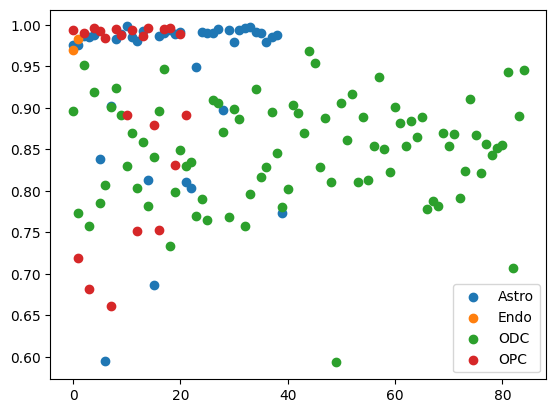

In [5]:
for cell_type in ['Astro', 'Endo', 'ODC', 'OPC']:
    _values, _ = cal_by_cell_type(cell_type)
    plt.scatter(list(range(0, len(_values))), _values, label=cell_type)

plt.legend()
plt.show()

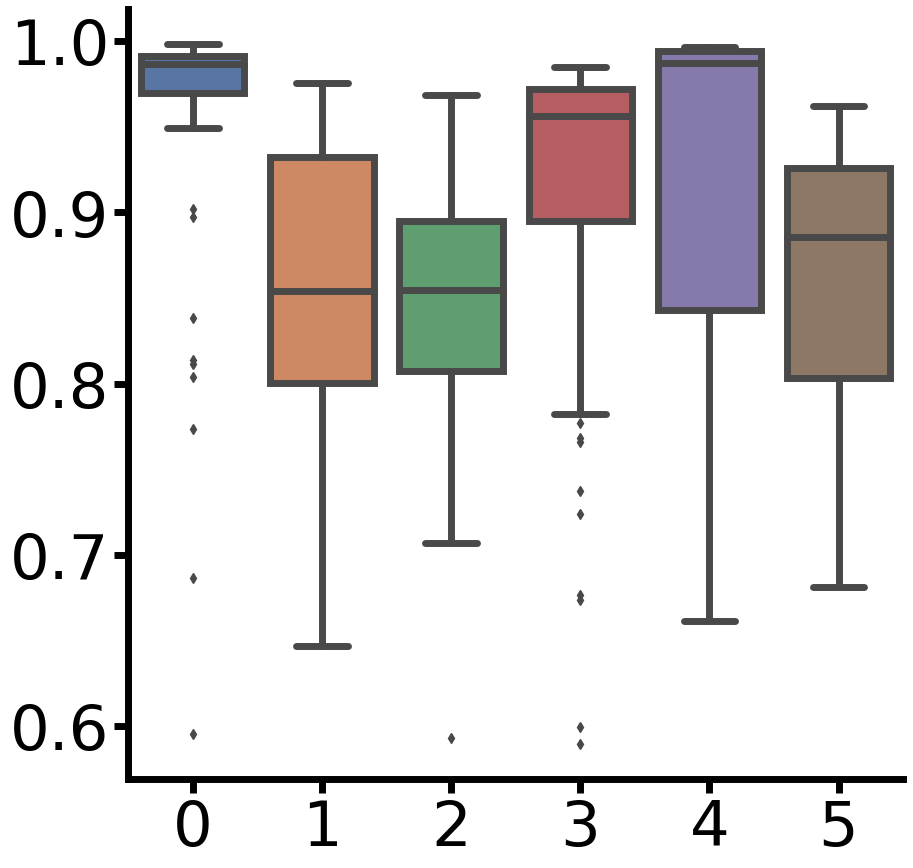

In [6]:
set_plt(figsize=(10, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

plot_values = []
for cell_type in ['Astro', 'ODC', 'OPC']:
    _values, _negative_values = cal_by_cell_type(cell_type)
    plot_values.append(_values)
    plot_values.append(_negative_values)
#     plot_values[cell_type] = _values
#     plot_values['{}_n'.format(cell_type)] = _negative_values
# plot_values.append(cal_by_cell_type(cell_type)[1])
ax = sns.boxplot(data=plot_values, linewidth=figure_size['very_small'])

# ax.set_xticklabels(labels=['Astro', 'ODC', 'OPC', 'OPC vs other'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

# plt.xlabel("Pearson", fontsize=figure_size['ultra'])
# plt.ylabel("Cell Type", fontsize=figure_size['ultra'])
# plt.savefig('/lmh_data/work/SEE/analyse/figure_file/PDGFRA pearson.pdf', format='pdf', bbox_inches='tight')
plt.show()